# Classifying album covers to genres
## Loading our images as a dataset
First, we are going to see how we can load our album cover images as a dataset. The goal is to be able to use these images like we used the MNIST dataset. We define a function that goes through the specified path, converts the images to arrays and then appends them to the array $X$. Also it appends the class of the index to the array $y$. Then we use the Scikit-learn function train_test_split to split $X$ and $y$ into $X_{train}$, $X_{test}$, $y_{train}$, $y_{test}$ and return these variables.

In [110]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

# define some useful constants
DATA_PATH = './data/covers_original/'
CATEGORIES = ['electronic', 'hiphop', 'jazz', 'pop', 'rock']
IMG_SIZE = 150
CATEGORIES_SIZE = 5
TRAIN_PERC = 0.8
TEST_PERC = 0.2

# define a function that creates the dataset
def load_data():
    X = []
    y = []
    # training data
    for category in CATEGORIES:
        path = os.path.join(DATA_PATH, category) # '../data/covers_original/<category>'
        cn = CATEGORIES.index(category) # get index of class name (e.g. 'electronic' => 0, 'rock' => 4)
        
        for img in os.listdir(path):
            try:
                img = load_img(os.path.join(path, img), target_size=(IMG_SIZE, IMG_SIZE))
                img_as_array = img_to_array(img)
                X.append(img_as_array)
                y.append(cn)
            except Exception as e:
                print(e)
    X = np.array(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_PERC)
    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = load_data()

# reshape and normalize the data
X_train = X_train.reshape((4000, IMG_SIZE, IMG_SIZE, 3))
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape((1000, IMG_SIZE, IMG_SIZE, 3))
X_test = X_test.astype('float32') / 255

# one-hot encode the class labels (0-9)
y_train = np_utils.to_categorical(y_train, CATEGORIES_SIZE)
y_test = np_utils.to_categorical(y_test, CATEGORIES_SIZE)


2


[2106, 2904, 10, 3387, 737, 1243, 2923, 2801, 1610, 3896]
Image 2106:


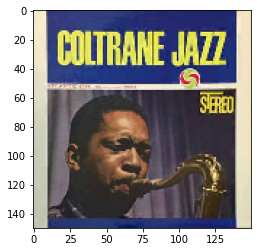

Class: [0. 0. 1. 0. 0.]
Image 2904:


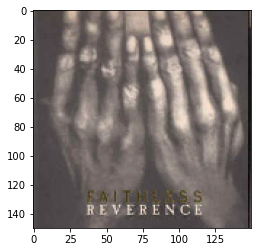

Class: [0. 1. 0. 0. 0.]
Image 10:


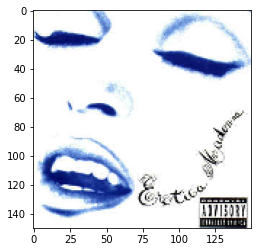

Class: [1. 0. 0. 0. 0.]
Image 3387:


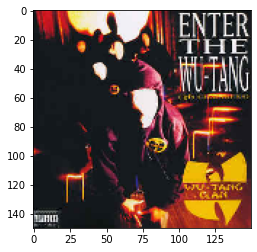

Class: [0. 1. 0. 0. 0.]
Image 737:


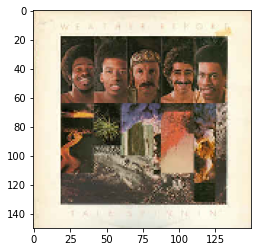

Class: [0. 0. 1. 0. 0.]
Image 1243:


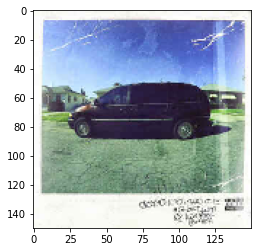

Class: [0. 1. 0. 0. 0.]
Image 2923:


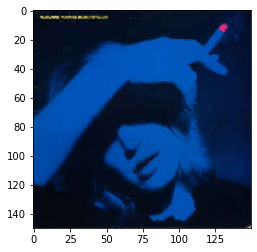

Class: [0. 0. 0. 0. 1.]
Image 2801:


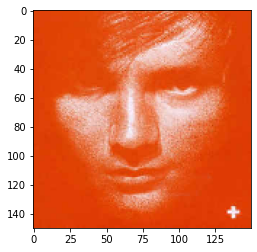

Class: [0. 1. 0. 0. 0.]
Image 1610:


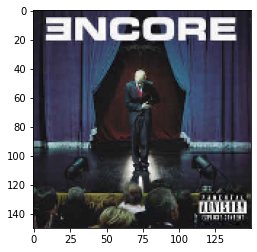

Class: [0. 1. 0. 0. 0.]
Image 3896:


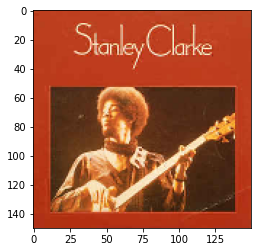

Class: [0. 0. 1. 0. 0.]


In [54]:
# to make sure that it actually works
permutation = random.sample(range(1, 4000), 10)
print(permutation)
for i in permutation:
    print('Image %d:' % i)
    img = array_to_img(X_train[i])
    plt.imshow(img)
    plt.show()
    print('Class:', y_train[i])

## The first model for our CNN.
Now we are going to describe our model for our CNN. We use the same model as we did when classifying the mnist digits. 

In [20]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten

# describe model architecture
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', strides=(1,1), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Conv2D(64, (5, 5), activation='relu', strides=(1,1), padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu')) # reduced 1024 to 64 because of OOM Exceptions
model.add(Dense(5, activation='softmax'))
model.summary()

# compile model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
history = model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_split=0.2)

# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 200, 200, 32)      2432      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 100, 100, 64)      51264     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 160000)            0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                10240064  
_________________________________________________________________
dense_31 (Dense)             (None, 5)               

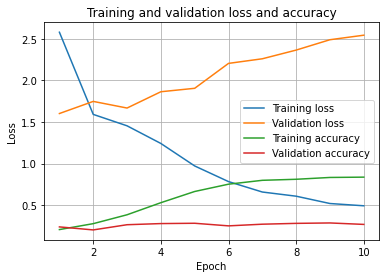

In [4]:
history_dict = history.history
train_loss = history_dict['loss']
train_acc = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss and accuracy')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

As we see above we only reach about $0.30$ ($30$%) accuracy. Maybe this is due to images belonging to more than one class (i.e. a cover may belong to both electronic and hiphop). Also we should reduce complexity, because it has ~$10.3$ million parameters to train.

## Try to increase accuracy
To increase accuracy, we may have to deal with covers belonging to more than one label. To do this, we change the activation function of our last layer to sigmoid instead of softmax. Also we are using binary crossentropy as a loss function instead of categorical crossentropy. To reduce complexity, we also reduced the number of filters for the layers.

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten

# describe model architecture
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', strides=(1,1), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Conv2D(64, (5, 5), activation='relu', strides=(1,1), padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
model.summary()

# compile model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
# history = model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_test, y_test)) # das hier dürfte falsch sein, da validation und test data nicht die selben sein sollten
history = model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, validation_split=0.2)

# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 87616)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                5607488   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 3

KeyboardInterrupt: 

As we can see, changing our activation function from softmax to sigmoid in our output layer, as well as using binary_crossentropy instead of categorical_crossentropy, helps to increase accuracy to about $76$% ($\lfloor0.763\rfloor$). But something still seems to be wrong, because our accuracy decreases from $80$% to ~$76$%. It seems that our model is overfitting.

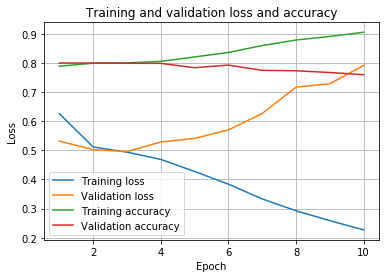

In [8]:
history_dict = history.history
train_loss = history_dict['loss']
train_acc = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss and accuracy')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## Introducing Dropout
Now we will see how it performs when introducing Dropout to avoid overfitting.

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout

# describe model architecture
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', strides=(1,1), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(Dropout(0.5))

model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (5, 5), activation='relu', strides=(1,1), padding='same'))
model.add(Dropout(0.5))

model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='sigmoid'))
model.summary()

# compile model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
history = model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, validation_split=0.2)

# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
dropout_6 (Dropout)          (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 64)        51264     
_________________________________________________________________
dropout_8 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 37, 37, 64)       

Epoch 44/100
50/50 [==============================] - 3s 51ms/step - loss: 0.3799 - accuracy: 0.5441 - val_loss: 0.5020 - val_accuracy: 0.2750
Epoch 45/100
50/50 [==============================] - 3s 51ms/step - loss: 0.3845 - accuracy: 0.5288 - val_loss: 0.5045 - val_accuracy: 0.2375
Epoch 46/100
50/50 [==============================] - 3s 51ms/step - loss: 0.3751 - accuracy: 0.5531 - val_loss: 0.4996 - val_accuracy: 0.2550
Epoch 47/100
50/50 [==============================] - 3s 51ms/step - loss: 0.3770 - accuracy: 0.5509 - val_loss: 0.5015 - val_accuracy: 0.2475
Epoch 48/100
50/50 [==============================] - 3s 54ms/step - loss: 0.3851 - accuracy: 0.5550 - val_loss: 0.5032 - val_accuracy: 0.2387
Epoch 49/100
50/50 [==============================] - 3s 50ms/step - loss: 0.3773 - accuracy: 0.5437 - val_loss: 0.5058 - val_accuracy: 0.2200
Epoch 50/100
50/50 [==============================] - 3s 50ms/step - loss: 0.3758 - accuracy: 0.5484 - val_loss: 0.5022 - val_accuracy: 0.2262

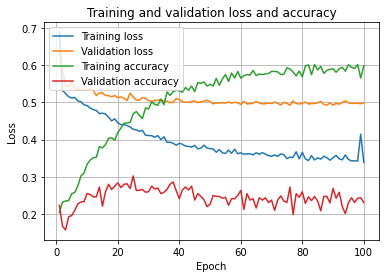

In [7]:
history_dict = history.history
train_loss = history_dict['loss']
train_acc = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss and accuracy')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Our validation accuracy does not drop anymore but is stuck at $80$%. Also training and validation loss are decreasing.

## Test how it classifies a single image after training
To test this, we will load a single image, reshape and normalize it and then use model.predict to get the class probabilities.

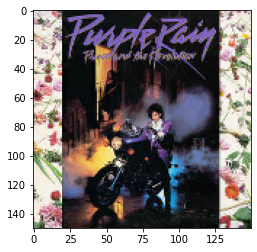

array([[0.24471295, 0.19916525, 0.21795562, 0.21654437, 0.26752084]],
      dtype=float32)

In [8]:
img = load_img('./data/covers_original/electronic/electronic.1.jpeg', target_size=(IMG_SIZE, IMG_SIZE))
img_as_array = img_to_array(img)
plt.imshow(img)
plt.show()
img_as_array = np.array(img_as_array)
img_as_array = img_as_array.reshape(1, IMG_SIZE, IMG_SIZE, 3)
img_as_array = img_as_array.astype('float32') / 255

model.predict(img_as_array)

## Loading our dataset with ImageDataGenerator class with data augmentation
Because we only have 5000 covers to use as our dataset, we are going to load our dataset using the ImageDataGenerator class applying data augmentation at the same time. Maybe this will help with reducing or avoiding overfitting.
First we are going to convert our original dataset to a format, that we can use with ImageDataGenerator.

In [10]:
import shutil
from random import shuffle

DATA_DEST = './data/covers'
VALIDATION_PERC = 0.1
TEST_PERC = 0.1

categories = os.listdir(DATA_PATH)

# unfortunately this is too slow, removing the directory 
# using finder or explorer is way faster
# remove directory if it already exists (for convenience)
# if os.path.exists(DATA_DEST):
#     shutil.rmtree(DATA_DEST)
        
for category in categories:
    # set up some paths
    oldCategoryPath = os.path.join(DATA_PATH, category)
    newCategoryTrainingPath = os.path.join(os.path.join(DATA_DEST, 'training'), category)
    newCategoryValidationPath = os.path.join(os.path.join(DATA_DEST, 'validation'), category)
    newCategoryTestPath = os.path.join(os.path.join(DATA_DEST, 'test'), category)

    # get all files of each category
    files = os.listdir(os.path.join(DATA_PATH, category))
    
    # make a directory for each category
    os.makedirs(newCategoryTrainingPath)
    os.makedirs(newCategoryValidationPath)
    os.makedirs(newCategoryTestPath)
    
    # for each category, see how far we have to run for training and validation images.
    training_end = int((1-(VALIDATION_PERC + TEST_PERC)) * len(files))
    validation_end = training_end + int(VALIDATION_PERC * len(files))
    test_end = validation_end + int(TEST_PERC * len(files))
    
    # separate training and validation files
    training_files = files[:training_end]
    validation_files = files[training_end:validation_end]
    test_files = files[validation_end:test_end]
    print('Training files:', len(training_files))
    print('Validation files:', len(validation_files))
    print('Test files:', len(test_files))
    
    # shuffle files
#     shuffle(training_files)
#     shuffle(validation_files)
    
    # copy training files to training path
    for idx, file in enumerate(training_files):
        oldFilePath = os.path.join(oldCategoryPath, file)
        if file != '.DS_Store' and os.path.isfile(oldFilePath):
#             newFilename = category + '_image_' + str(idx) + '.jpeg'
            newFilePath = os.path.join(newCategoryTrainingPath, file)
            shutil.copy(oldFilePath, newFilePath)

    # copy validation files to validation path
    for idx, file in enumerate(validation_files):
        oldFilePath = os.path.join(oldCategoryPath, file)
        if file != '.DS_Store' and os.path.isfile(oldFilePath):
#             newFilename = category + '_image_' + str(idx) + '.jpeg'
            newFilePath = os.path.join(newCategoryValidationPath, file)
            shutil.copy(oldFilePath, newFilePath)
    
    # copy validation files to test path
    for idx, file in enumerate(test_files):
        oldFilePath = os.path.join(oldCategoryPath, file)
        if file != '.DS_Store' and os.path.isfile(oldFilePath):
#             newFilename = category + '_image_' + str(idx) + '.jpeg'
            newFilePath = os.path.join(newCategoryTestPath, file)
            shutil.copy(oldFilePath, newFilePath)

Training files: 800
Validation files: 100
Test files: 100
Training files: 800
Validation files: 100
Test files: 100
Training files: 800
Validation files: 100
Test files: 100
Training files: 800
Validation files: 100
Test files: 100
Training files: 800
Validation files: 100
Test files: 100


In [27]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

BATCH_SIZE = 20
IMG_SIZE = 200
training_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_gen = training_datagen.flow_from_directory(
    './data/covers/training',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
)

validation_gen = validation_datagen.flow_from_directory(
    './data/covers/validation',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
)

test_gen = test_datagen.flow_from_directory(
    './data/covers/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
)

# describe model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu', strides=(1,1), padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
model.summary()

# compile model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
history = model.fit(
    train_gen,
    steps_per_epoch=100,
    validation_data=validation_gen,
    validation_steps=10,
    epochs=10
)

# compute loss and accuracy on test data
score = model.evaluate(test_gen)
# score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Found 4000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 160000)            0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 160000)            0     

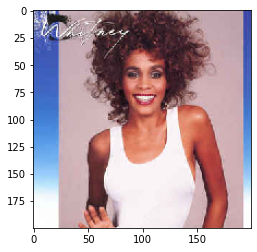

[[0.1886687  0.23147917 0.19468768 0.20419583 0.19095722]]


array([1], dtype=int64)

In [37]:
img = load_img('./data/covers/test/pop/pop.96.jpeg', target_size=(IMG_SIZE, IMG_SIZE))
img_as_array = img_to_array(img)
plt.imshow(img)
plt.show()
img_as_array = np.array(img_as_array)
img_as_array = img_as_array.reshape(1, IMG_SIZE, IMG_SIZE, 3)
img_as_array = img_as_array.astype('float32') / 255

print(model.predict(img_as_array))
model.predict_classes(img_as_array)
# (model.predict(img_as_array) > 0.5).astype("int32")

## Notiz
Evtl. wäre es sinnvoll eine CSV-Datei zu haben in denen die Labels und die Dateinamen drinstehen

In [43]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensor Flow Version: 2.2.0
Keras Version: 2.3.0-tf

Python 3.8.3 (tags/v3.8.3:6f8c832, May 13 2020, 22:37:02) [MSC v.1924 64 bit (AMD64)]
Pandas 1.0.5
Scikit-Learn 0.23.1
GPU is available


# Another approach structuring our dataset
Because we are trying to achieve a multi-label classification, we may not use the same file structure as we used before. The problem is that we see some images multiple times, but each time we only have one label "attached" to the image. Now we want to loop over all our images, check if we have seen the image before. If we have seen it before, we just set the index of the label in its array. For example we see image $A$ with label 'rock' and we save that information. Later we see that image again, but with another label. We dont save it as a duplicate, we just set the corresponding index to 1 in its label-array.

In [92]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from PIL import ImageChops

# define some useful constants
DATA_PATH = './data/covers_original/'
CATEGORIES = ['electronic', 'hiphop', 'jazz', 'pop', 'rock']
IMG_SIZE = 150
CATEGORIES_SIZE = 5
TRAIN_PERC = 0.8
TEST_PERC = 0.2

def equal(im1, im2):
    return ImageChops.difference(im1, im2).getbbox() is None

def findImg(img, array):
    for i, el in enumerate(array):
        if (el==img).all():
            return i
    return None

# define a function that creates the dataset
def load_data():
    X = []
    y = []
    dupes = 0
    # training data
    for category in CATEGORIES:
        path = os.path.join(DATA_PATH, category) # '../data/covers_original/<category>'
        cn = CATEGORIES.index(category) # get index of class name (e.g. 'electronic' => 0, 'rock' => 4)
        
        for img in os.listdir(path):
            try:
                img = load_img(os.path.join(path, img), target_size=(IMG_SIZE, IMG_SIZE))
                img_as_array = np.array(img_to_array(img))
                # check if we have seen that image before
                idx = findImg(img_as_array, X)
                # if we have seen it already, update only the labels
                if not idx is None:
                    dupes += 1 # just to see how many duplicates we have
                    # sometimes images are duplicate in their own categories too
                    if not category in y[idx]:
                        y[idx].append(category)
                else:
                    X.append(img_as_array)
                    labels = [category]
                    y.append(labels)
            except Exception as e:
                print(e)

    X = np.array(X)
#     y = np.array(y)
    print('Length X: ', len(X))
    print('Length y: ', len(y))
    print('Anzahl dupes: ', dupes)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_PERC)
    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = load_data()

# reshape and normalize the data
X_train = X_train.reshape((len(X_train), IMG_SIZE, IMG_SIZE, 3))
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape((len(X_test), IMG_SIZE, IMG_SIZE, 3))
X_test = X_test.astype('float32') / 255

# one-hot encode the class labels (0-9)
# y_train = np_utils.to_categorical(y_train, CATEGORIES_SIZE)
# y_test = np_utils.to_categorical(y_test, CATEGORIES_SIZE)


Length X:  4096
Length y:  4096
Anzahl dupes:  904


## Encode our labels

In [98]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

y_train = mlb.fit_transform(y_train)
y_test = mlb.fit_transform(y_test)

[2608, 1614, 44, 882, 3185, 3227, 2852, 2990, 1868, 668, 1349, 1271, 3022, 3248, 596, 1405, 1814, 2022, 679, 3159]
Image 2608:


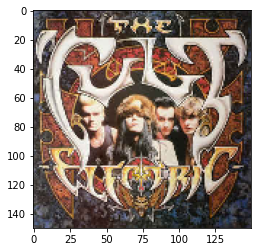

Class: [0 0 0 0 1]
Image 1614:


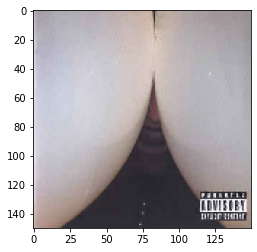

Class: [1 1 0 0 0]
Image 44:


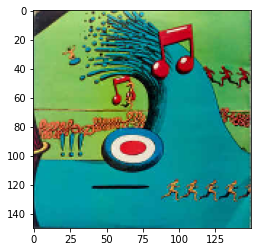

Class: [0 0 1 0 0]
Image 882:


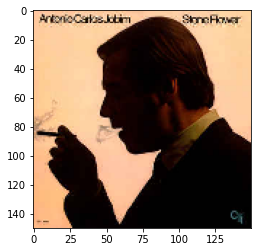

Class: [0 0 1 0 0]
Image 3185:


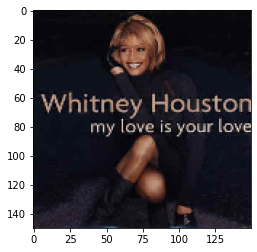

Class: [0 1 0 0 0]
Image 3227:


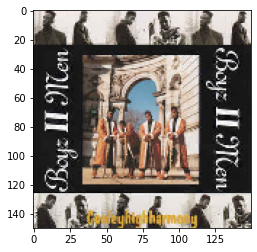

Class: [0 1 0 0 0]
Image 2852:


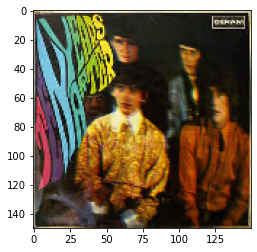

Class: [0 0 1 0 0]
Image 2990:


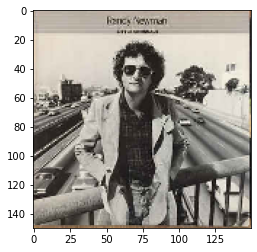

Class: [0 0 0 1 0]
Image 1868:


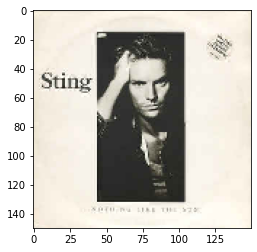

Class: [0 0 0 0 1]
Image 668:


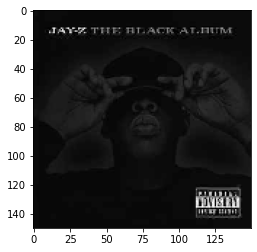

Class: [0 1 0 0 0]
Image 1349:


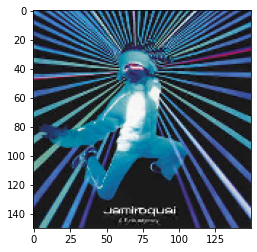

Class: [1 0 0 0 0]
Image 1271:


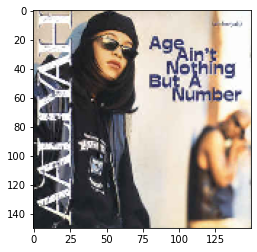

Class: [0 1 0 0 0]
Image 3022:


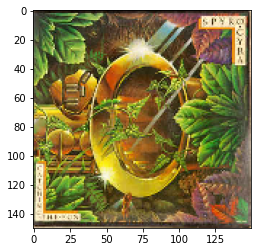

Class: [0 0 1 0 0]
Image 3248:


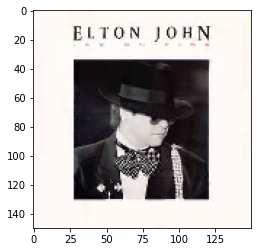

Class: [0 0 0 1 0]
Image 596:


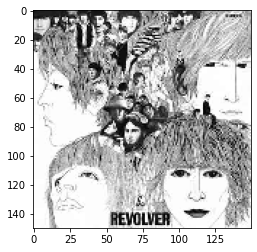

Class: [0 0 0 1 0]
Image 1405:


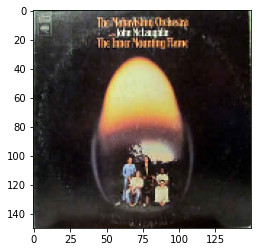

Class: [0 0 1 0 0]
Image 1814:


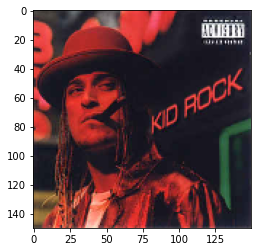

Class: [0 1 0 0 0]
Image 2022:


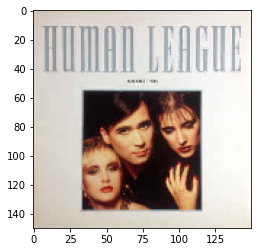

Class: [0 0 0 1 0]
Image 679:


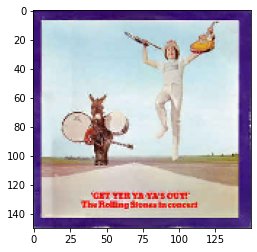

Class: [0 0 0 0 1]
Image 3159:


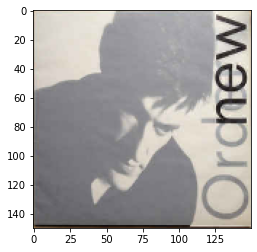

Class: [1 0 0 0 1]


In [99]:
# to make sure that it actually works
permutation = random.sample(range(1, len(X_train)), 20)
print(permutation)
for i in permutation:
    print('Image %d:' % i)
    img = array_to_img(X_train[i])
    plt.imshow(img)
    plt.show()
    print('Class:', y_train[i])

In [101]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout

# describe model architecture
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', strides=(1,1), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Conv2D(64, (5, 5), activation='relu', strides=(1,1), padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='sigmoid'))
model.summary()

# compile model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
# history = model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_test, y_test)) # das hier dürfte falsch sein, da validation und test data nicht die selben sein sollten
history = model.fit(X_train, y_train, batch_size=64, epochs=150, verbose=1, validation_split=0.2)

# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 75, 75, 64)        51264     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 87616)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                5607488   
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)               

41/41 [==============================] - 2s 39ms/step - loss: 0.0693 - accuracy: 0.9069 - val_loss: 2.0178 - val_accuracy: 0.3262
Epoch 49/150
41/41 [==============================] - 2s 39ms/step - loss: 0.0692 - accuracy: 0.9103 - val_loss: 1.6721 - val_accuracy: 0.3186
Epoch 50/150
41/41 [==============================] - 2s 40ms/step - loss: 0.0686 - accuracy: 0.8992 - val_loss: 1.3482 - val_accuracy: 0.3308
Epoch 51/150
41/41 [==============================] - 2s 39ms/step - loss: 0.0649 - accuracy: 0.9088 - val_loss: 2.4183 - val_accuracy: 0.3247
Epoch 52/150
41/41 [==============================] - 2s 39ms/step - loss: 0.0677 - accuracy: 0.9061 - val_loss: 2.0112 - val_accuracy: 0.3293
Epoch 53/150
41/41 [==============================] - 2s 40ms/step - loss: 0.0654 - accuracy: 0.9122 - val_loss: 2.1843 - val_accuracy: 0.3079
Epoch 54/150
41/41 [==============================] - 2s 40ms/step - loss: 0.0707 - accuracy: 0.9050 - val_loss: 1.6745 - val_accuracy: 0.3079
Epoch 55/150

41/41 [==============================] - 2s 39ms/step - loss: 0.0660 - accuracy: 0.9053 - val_loss: 2.5010 - val_accuracy: 0.3171
Epoch 106/150
41/41 [==============================] - 2s 39ms/step - loss: 0.0622 - accuracy: 0.9011 - val_loss: 1.6331 - val_accuracy: 0.3125
Epoch 107/150
41/41 [==============================] - 2s 39ms/step - loss: 0.0668 - accuracy: 0.9076 - val_loss: 3.1554 - val_accuracy: 0.3338
Epoch 108/150
41/41 [==============================] - 2s 39ms/step - loss: 0.0622 - accuracy: 0.9027 - val_loss: 2.2855 - val_accuracy: 0.3095
Epoch 109/150
41/41 [==============================] - 2s 39ms/step - loss: 0.0595 - accuracy: 0.9042 - val_loss: 2.5708 - val_accuracy: 0.3186
Epoch 110/150
41/41 [==============================] - 2s 39ms/step - loss: 0.0639 - accuracy: 0.9118 - val_loss: 2.4074 - val_accuracy: 0.3308
Epoch 111/150
41/41 [==============================] - 2s 40ms/step - loss: 0.0555 - accuracy: 0.9095 - val_loss: 2.5277 - val_accuracy: 0.3399
Epoch 

## Generating a Dataframe from our dataset
To test data augmentation using ImageDataGenerator we will create a pandas dataframe that contains the information about our images.